#Training Logistic Regression via Stochastic Gradient Ascent

In [1]:
import pandas as pd
import numpy as np
products = pd.read_csv('/Users/April/Downloads/amazon_baby_subset.csv')
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


In [2]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

In [3]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [4]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [6]:
import json
with open('/Users/April/Desktop/datasci_course_materials-master/assignment1/important words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]
print important_words

['baby', 'one', 'great', 'love', 'use', 'would', 'like', 'easy', 'little', 'seat', 'old', 'well', 'get', 'also', 'really', 'son', 'time', 'bought', 'product', 'good', 'daughter', 'much', 'loves', 'stroller', 'put', 'months', 'car', 'still', 'back', 'used', 'recommend', 'first', 'even', 'perfect', 'nice', 'bag', 'two', 'using', 'got', 'fit', 'around', 'diaper', 'enough', 'month', 'price', 'go', 'could', 'soft', 'since', 'buy', 'room', 'works', 'made', 'child', 'keep', 'size', 'small', 'need', 'year', 'big', 'make', 'take', 'easily', 'think', 'crib', 'clean', 'way', 'quality', 'thing', 'better', 'without', 'set', 'new', 'every', 'cute', 'best', 'bottles', 'work', 'purchased', 'right', 'lot', 'side', 'happy', 'comfortable', 'toy', 'able', 'kids', 'bit', 'night', 'long', 'fits', 'see', 'us', 'another', 'play', 'day', 'money', 'monitor', 'tried', 'thought', 'never', 'item', 'hard', 'plastic', 'however', 'disappointed', 'reviews', 'something', 'going', 'pump', 'bottle', 'cup', 'waste', 'retu

In [7]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [8]:
products['contains_perfect'] = products['perfect'].apply(lambda pf: 1 if pf >=1 else 0)

In [9]:
sum(products['contains_perfect'] == 1)

2955

#Convert data frame to multi-dimensional array

It is now time to convert our data frame to a multi-dimensional array. Look for a package that provides a highly optimized matrix operations. In the case of Python, NumPy is a good choice.
Write a function that extracts columns from a data frame and converts them into a multi-dimensional array. We plan to use them throughout the course, so make sure to get this function right.
The function should accept three parameters:
dataframe: a data frame to be converted features: a list of string, containing the names of the columns that are used as features. label: a string, containing the name of the single column that is used as class labels. The function should return two values:
one 2D array for features one 1D array for class labels The function should do the following:
Prepend a new column constant to dataframe and fill it with 1's. This column takes account of the intercept term. Make sure that the constant column appears first in the data frame. Prepend a string 'constant' to the list features. Make sure the string 'constant' appears first in the list. Extract columns in dataframe whose names appear in the list features. Convert the extracted columns into a 2D array using a function in the data frame library. If you are using Pandas, you would use as_matrix() function. Extract the single column in dataframe whose name corresponds to the string label. Convert the column into a 1D array. Return the 2D array and the 1D array.

In [10]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.as_matrix()
    label_sarray = dataframe[label]
    label_array = label_sarray.as_matrix()
    return(feature_matrix, label_array)

In [15]:
with open('/Users/April/Desktop/datasci_course_materials-master/assignment1/train index.json', 'r') as f1:
    train_index = json.load(f1)

In [16]:
with open('/Users/April/Desktop/datasci_course_materials-master/assignment1/validation index.json', 'r') as f2:
    validation_index = json.load(f2)

In [17]:
train_data = products.iloc[train_index]

In [18]:
validation_data = products.iloc[validation_index]

In [19]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

/Users/April/anaconda/envs/dato-env/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


#Building on logistic regression

In [20]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1/(1+np.exp(-score))
    
    # return predictions
    return predictions

In [21]:
def feature_derivative(errors, feature): 
   
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(errors, feature) 
    
    return derivative

In [22]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):

    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)   
    
    return lp

#Modifying the derivative for stochastic gradient ascent

Recall from the lecture that the gradient for a single data point $\color{red}{\mathbf{x}_i}$ can be computed using the following formula:
$$
\frac{\partial\ell_{\color{red}{i}}(\mathbf{w})}{\partial w_j} = h_j(\color{red}{\mathbf{x}_i})\left(\mathbf{1}[y_\color{red}{i} = +1] - P(y_\color{red}{i} = +1 | \color{red}{\mathbf{x}_i}, \mathbf{w})\right)
$$
Computing the gradient for a single data point
Do we really need to re-write all our code to modify $\partial\ell(\mathbf{w})/\partial w_j$ to $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$?
Thankfully No!. Using NumPy, we access $\mathbf{x}_i$ in the training data using feature_matrix_train[i:i+1,:] and $y_i$ in the training data using sentiment_train[i:i+1]. We can compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ by re-using all the code written in feature_derivative and predict_probability.
We compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ using the following steps:
First, compute $P(y_i = +1 | \mathbf{x}_i, \mathbf{w})$ using the predict_probability function with feature_matrix_train[i:i+1,:] as the first parameter.
Next, compute $\mathbf{1}[y_i = +1]$ using sentiment_train[i:i+1].
Finally, call the feature_derivative function with feature_matrix_train[i:i+1, j] as one of the parameters.
Let us follow these steps for j = 1 and i = 10:

In [24]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print "Gradient single data point: %s" % gradient_single_data_point
print "           --> Should print 0.0"

Gradient single data point: 0.0
           --> Should print 0.0


Stochastic gradient estimates the ascent direction using 1 data point, while gradient uses $N$ data points to decide how to update the the parameters. In an optional video, we discussed the details of a simple change that allows us to use a mini-batch of $B \leq N$ data points to estimate the ascent direction. This simple approach is faster than regular gradient but less noisy than stochastic gradient that uses only 1 data point. Although we encorage you to watch the optional video on the topic to better understand why mini-batches help stochastic gradient, in this assignment, we will simply use this technique, since the approach is very simple and will improve your results.
Given a mini-batch (or a set of data points) $\mathbf{x}_{i}, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$, the gradient function for this mini-batch of data points is given by:

Using NumPy, we access the points $\mathbf{x}_i, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$ in the training data using feature_matrix_train[i:i+B,:] and $y_i$ in the training data using sentiment_train[i:i+B].
We can compute $\color{red}{\sum_{s = i}^{i+B}} \partial\ell_{s}/\partial w_j$ easily as follows:

In [25]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions        
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print "Gradient mini-batch data points: %s" % gradient_mini_batch
print "                --> Should print 1.0"

Gradient mini-batch data points: 1.0
                --> Should print 1.0


Quiz Question: The code block above computed  $\color{red}{\sum_{s = i}^{i+B}}\partial\ell_{s}(\mathbf{w})/{\partial w_j}$ for j = 10, i = 10, and B = 10. Is this a scalar or a 194-dimensional vector?

Quiz Question: For what value of B is the term $\color{red}{\sum_{s = 1}^{B}}\partial\ell_{s}(\mathbf{w})/\partial w_j$ the same as the full gradient $\partial\ell(\mathbf{w})/{\partial w_j}$?

In [26]:
len(feature_matrix_train)

47780

#Averaging the gradient across a batch

It is a common practice to normalize the gradient update rule by the batch size B:
$$
\frac{\partial\ell_{\color{red}{A}}(\mathbf{w})}{\partial w_j} \approx \color{red}{\frac{1}{B}} {\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$
In other words, we update the coefficients using the average gradient over data points (instead of using a summation). By using the average gradient, we ensure that the magnitude of the gradient is approximately the same for all batch sizes. This way, we can more easily compare various batch sizes of stochastic gradient ascent (including a batch size of all the data points), and study the effect of batch size on the algorithm as well as the choice of step size.

##Implementing stochastic gradient ascent

In [27]:
from math import sqrt
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []
    
    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]
    
    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        predictions = predict_probability(feature_matrix[i:i+batch_size,:], coefficients)
        
        
        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        indicator = sentiment[i:i+batch_size] == +1
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j])
            
            # compute the product of the step size, the derivative, and the **normalization constant** (1./batch_size)
            coefficients[j] += step_size * derivative * 1./batch_size
        
        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print 'Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp)
        
        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0
                
    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

In [28]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2)
print '-------------------------------------------------------------------------------------'
print 'Coefficients learned                 :', coefficients
print 'Average log likelihood per-iteration :', log_likelihood
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print '-------------------------------------------------------------------------------------'
    print 'Test passed!'
else:
    print '-------------------------------------------------------------------------------------'
    print 'Test failed'

Iteration 0: Average log likelihood (of data points in batch [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points in batch [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.23455309394103413]
-------------------------------------------------------------------------------------
Test passed!


#Running gradient ascent using the stochastic gradient ascent implementation

Instead of implementing batch gradient ascent separately, we save time by re-using the stochastic gradient ascent function we just wrote — to perform gradient ascent, it suffices to set batch_size to the number of data points in the training data. Yes, we did answer above the quiz question for you, but that is an important point to remember in the future :)

Small Caveat. The batch gradient ascent implementation here is slightly different than the one in the earlier assignments, as we now normalize the gradient update rule.

We now run stochastic gradient ascent over the feature_matrix_train for 10 iterations using:

In [29]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = 1
max_iter = 10


Quiz Question. When you set batch_size = 1, as each iteration passes, how does the average log likelihood in the batch change?

Quiz Question. When you set batch_size = len(train_data), as each iteration passes, how does the average log likelihood in the batch change?

To make a fair comparison betweeen stochastic gradient ascent and batch gradient ascent, we measure the average log likelihood as a function of the number of passes (defined as follows):

o make a fair comparison betweeen stochastic gradient ascent and batch gradient ascent, we measure the average log likelihood as a function of the number of passes (defined as follows): $$
[\text{# of passes}] = \frac{[\text{# of data points touched so far}]}{[\text{size of dataset}]}
$$
Quiz Question Suppose that we run stochastic gradient ascent with a batch size of 100. How many gradient updates are performed at the end of two passes over a dataset consisting of 50000 data points?

#Log likelihood plots for stochastic gradi

In [30]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [01000

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')
    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

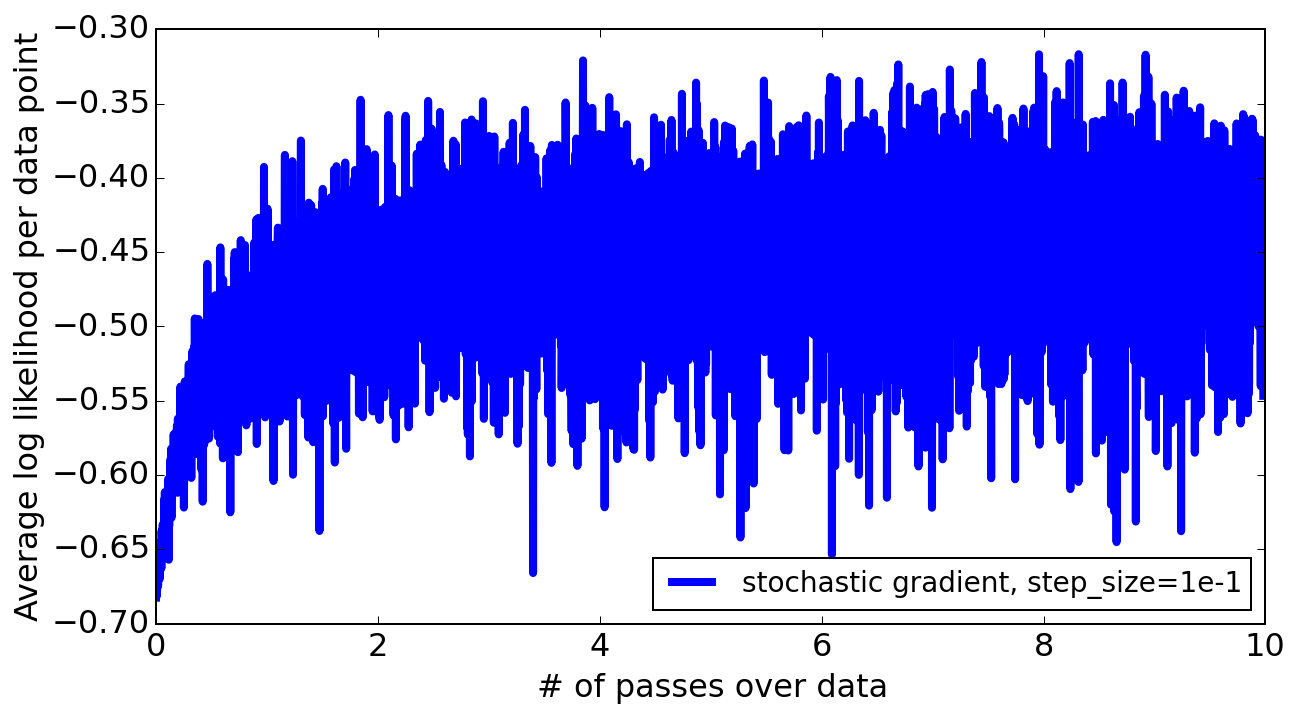

In [32]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          label='stochastic gradient, step_size=1e-1')

#Smoothing the stochastic gradient ascent curve

The plotted line oscillates so much that it is hard to see whether the log likelihood is improving. In our plot, we apply a simple smoothing operation using the parameter smoothing_window. The smoothing is simply a moving average of log likelihood over the last smoothing_window "iterations" of stochastic gradient ascent.

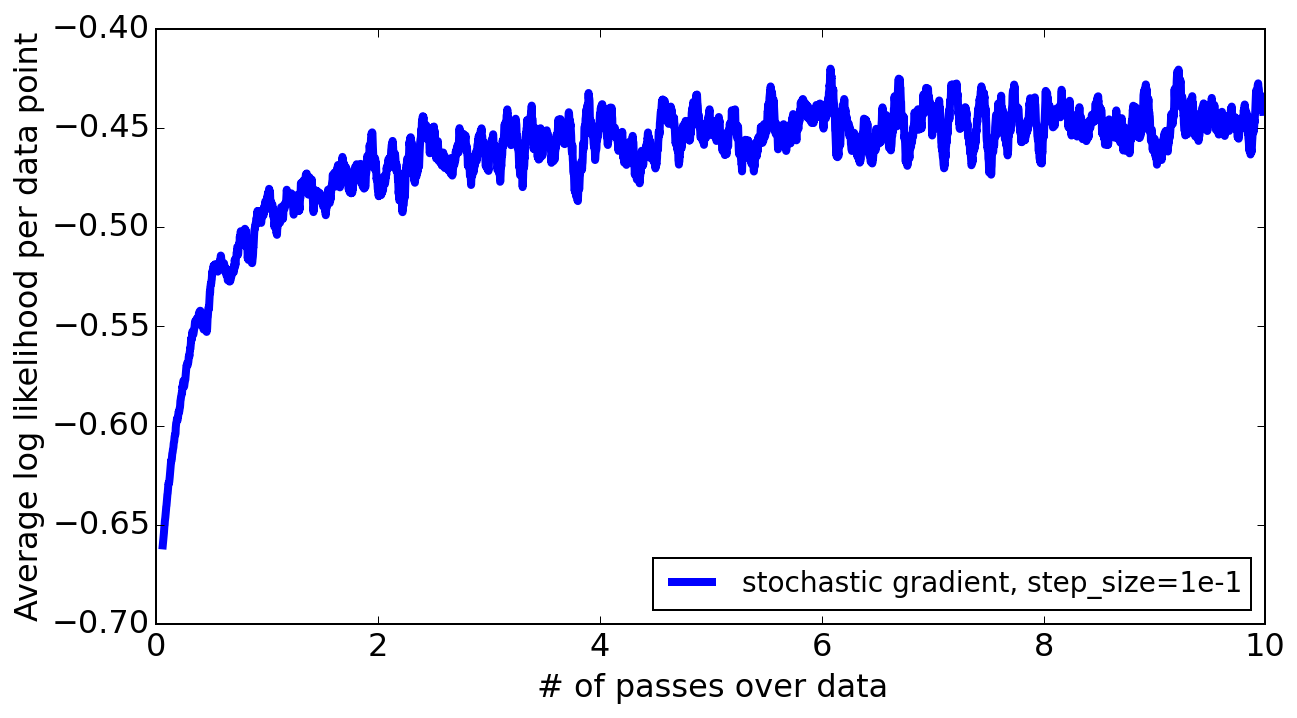

In [33]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

#Stochastic gradient ascent vs batch gradient ascent